In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt


In [2]:
!unzip /kaggle/input/quora-question-pairs/train.csv.zip

Archive:  /kaggle/input/quora-question-pairs/train.csv.zip
  inflating: train.csv               


In [3]:
import random
import pandas as pd
from keras.models import Sequential
from keras.preprocessing import sequence
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt


In [4]:
data = pd.read_csv('train.csv')

In [5]:
data = data.dropna()
data = data.reset_index(drop=True)
data.shape[0]

404287

In [6]:
def pre_processing(data):
    data['question1'] = data['question1'].str.lower()
    data['question2'] = data['question2'].str.lower()
    #Removing tags present in review
    data['question1'] = data['question1'].str.replace('<.*?>','')
    data['question2'] = data['question2'].str.replace('<.*?>','')
    #Removing URLs present in review
    data['question1'] = data['question1'].str.replace(r'http\S+','')
    data['question2'] = data['question2'].str.replace(r'http\S+','')
    #Removing punctuations
    data['question1'] = data['question1'].str.replace('[^\w\s]','')
    data['question2'] = data['question2'].str.replace('[^\w\s]','')
    return data

In [7]:
data = pre_processing(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex wil

In [8]:
# Shuffle the data
seed = 1337
data = data.sample(frac = 1, random_state=seed)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(data))
train_data = data[:-num_validation_samples]
val_data = data[-num_validation_samples:]

In [9]:
train_question1 = train_data['question1']
train_question2 = train_data['question2']
train_label = train_data['is_duplicate']

val_question1 = val_data['question1']
val_question2 = val_data['question2']
val_label = val_data['is_duplicate']

In [10]:
all_train_sentence = pd.concat([train_question1, train_question2], ignore_index=True)
all_train_sentence.shape[0]

646860

In [11]:
vectorizer = layers.TextVectorization(max_tokens=50000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(all_train_sentence).batch(128)
vectorizer.adapt(text_ds)

2021-12-11 08:15:46.928397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 08:15:47.051431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 08:15:47.052548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 08:15:47.054645: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

50000

In [13]:
path_to_glove_file = "/kaggle/input/glove6b/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [14]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 39839 words (10161 misses)


In [15]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

input1 = keras.Input(shape=(None,), dtype="string")
input2 = keras.Input(shape=(None,), dtype="string")

int_sequences_input1 = vectorizer(input1)
int_sequences_input2 = vectorizer(input2)

embedded_sequence1 = embedding_layer(int_sequences_input1)
embedded_sequence2 = embedding_layer(int_sequences_input2)

shared_lstm_1 = layers.LSTM(100) 
# shared_lstm_1 = layers.LSTM(100, return_sequences=True) 
# shared_lstm_2 = layers.LSTM(50)

x1 = shared_lstm_1(embedded_sequence1)
# x1 = shared_lstm_2(x1)

x2 = shared_lstm_1(embedded_sequence2)
# x2 = shared_lstm_2(x2)

x = layers.Concatenate(axis=-1)([x1,x2])
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

dense_layer1 = layers.Dense(50, activation="relu")
x = dense_layer1(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

preds = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([input1, input2], preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 50)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      5000200     text_vectorization[0][0]     

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
history = model.fit([train_question1,train_question2], train_label, 
                    batch_size=128, epochs=20, callbacks=[callback],
                    validation_data=([val_question1, val_question2], val_label))

Epoch 1/20


2021-12-11 08:16:21.926907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2527/2527 [==============================] - 73s 26ms/step - loss: 0.5669 - acc: 0.7020 - precision: 0.6319 - recall: 0.4634 - val_loss: 0.5298 - val_acc: 0.7317 - val_precision: 0.7408 - val_recall: 0.4170
Epoch 2/20
2527/2527 [==============================] - 66s 26ms/step - loss: 0.5013 - acc: 0.7521 - precision: 0.6988 - recall: 0.5781 - val_loss: 0.5390 - val_acc: 0.7087 - val_precision: 0.8500 - val_recall: 0.2533
Epoch 3/20
2527/2527 [==============================] - 67s 27ms/step - loss: 0.4737 - acc: 0.7701 - precision: 0.7145 - recall: 0.6292 - val_loss: 0.4711 - val_acc: 0.7737 - val_precision: 0.7257 - val_recall: 0.6194
Epoch 4/20
2527/2527 [==============================] - 68s 27ms/step - loss: 0.4544 - acc: 0.7817 - precision: 0.7253 - recall: 0.6587 - val_loss: 0.4705 - val_acc: 0.7711 - val_precision: 0.7492 - val_recall: 0.5686
Epoch 5/20
2527/2527 [==============================] - 68s 27ms/step - loss: 0.4382 - acc: 0.7917 - precision: 0.7343 - recall: 0.6838 - v

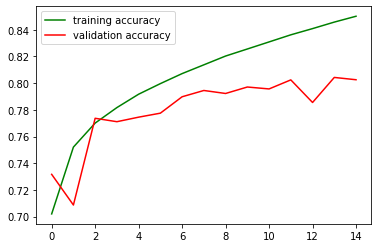

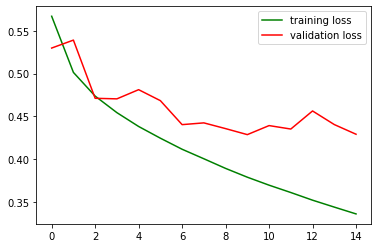

In [17]:
accuracy = history.history["acc"]
loss = history.history["loss"]

val_accuracy = history.history["val_acc"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [18]:
model.save('lstm_siemese_v5')

2021-12-11 08:34:06.828288: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
!zip -r lstm_siemese.zip lstm_siemese

	zip warning: name not matched: lstm_siemese

zip error: Nothing to do! (try: zip -r lstm_siemese.zip . -i lstm_siemese)


In [20]:
test_data = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv')
test_data = test_data.fillna('')

In [21]:
batches = list(range(0,2345796, 234580))
batches.append(2345796)
batches

[0,
 234580,
 469160,
 703740,
 938320,
 1172900,
 1407480,
 1642060,
 1876640,
 2111220,
 2345796]

In [22]:
#takes about 35 mins
probabilities = np.array([])
for i in tqdm(range(len(batches) - 1)):
    start = batches[i]
    end = batches[i+1]
    test_question1 = test_data['question1'][start:end]
    test_question2 = test_data['question2'][start:end]
    probs = model.predict([test_question1, test_question2])
    probs = probs.reshape(-1)
    probabilities = np.concatenate([probabilities, probs])

100%|██████████| 10/10 [11:19<00:00, 67.97s/it]


In [23]:
output = test_data[['test_id']]
output.shape
output['is_duplicate'] = probabilities

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
output.to_csv('lstm_siemese_v5.csv',index=False)

In [25]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

input1 = keras.Input(shape=(None,), dtype="string")
input2 = keras.Input(shape=(None,), dtype="string")

int_sequences_input1 = vectorizer(input1)
int_sequences_input2 = vectorizer(input2)

embedded_sequence1 = embedding_layer(int_sequences_input1)
embedded_sequence2 = embedding_layer(int_sequences_input2)

shared_cnn1d = layers.Conv1D(50, 3, padding='same', activation='relu')

# shared_lstm_1 = layers.LSTM(100) 
shared_lstm_1 = layers.LSTM(100, return_sequences=True) 
# shared_lstm_2 = layers.LSTM(50)

x1 = shared_lstm_1(embedded_sequence1)
# x1 = shared_lstm_2(x1)
x1 = shared_cnn1d(embedded_sequence1)
x1 = layers.MaxPooling1D()(x1)
x1 = layers.Flatten()(x1)

x2 = shared_lstm_1(embedded_sequence2)
# x2 = shared_lstm_2(x2)

x2 = shared_cnn1d(x2)
x2 = layers.MaxPooling1D()(x2)
x2 = layers.Flatten()(x2)

x = layers.Concatenate(axis=-1)([x1,x2])
x = layers.Dropout(0.2)(x)

dense_layer1 = layers.Dense(50, activation="relu")
x = dense_layer1(x)
x = layers.Dropout(0.2)(x)

preds = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([input1, input2], preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 50)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      5000200     text_vectorization[2][0]   

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
history = model.fit([train_question1,train_question2], train_label, 
                    batch_size=128, epochs=20, callbacks=[callback],
                    validation_data=([val_question1, val_question2], val_label))

Epoch 1/20
2527/2527 [==============================] - 52s 18ms/step - loss: 0.5535 - acc: 0.7159 - val_loss: 0.5217 - val_acc: 0.7377
Epoch 2/20
2527/2527 [==============================] - 44s 17ms/step - loss: 0.5098 - acc: 0.7480 - val_loss: 0.5110 - val_acc: 0.7405
Epoch 3/20
2527/2527 [==============================] - 49s 19ms/step - loss: 0.4910 - acc: 0.7593 - val_loss: 0.4943 - val_acc: 0.7577
Epoch 4/20
2527/2527 [==============================] - 46s 18ms/step - loss: 0.4760 - acc: 0.7689 - val_loss: 0.4895 - val_acc: 0.7579
Epoch 5/20
2527/2527 [==============================] - 45s 18ms/step - loss: 0.4652 - acc: 0.7758 - val_loss: 0.4776 - val_acc: 0.7690
Epoch 6/20
2527/2527 [==============================] - 52s 20ms/step - loss: 0.4544 - acc: 0.7815 - val_loss: 0.4719 - val_acc: 0.7698
Epoch 7/20
2527/2527 [==============================] - 45s 18ms/step - loss: 0.4450 - acc: 0.7875 - val_loss: 0.4692 - val_acc: 0.7721
Epoch 8/20
2527/2527 [==========================